In [333]:
#!pip install geopandas
#!pip install geopy
#!pip install shapely
#!pip install pyproj
#!pip install -U scikit-learn

In [1598]:
import random
import string
import geopy.distance
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from copy import copy
from math import radians
from sklearn.cluster import KMeans
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import box

In [1599]:
number_of_demand_nodes = 30 #50
number_of_warehouse = 6 #6
num_skus = 100 #100
capacity_over_demand_index = 1.2
max_capacity_overtaken = 0.3
track_num_of_pallets = 20
avg_num_of_units_on_pallet = 50
cost_per_km = 1.6 # $
real_vs_shortest_distace = 1.4 #
percent_of_non_zero_itemsets = 0.05

In [1600]:
# columns mapping
file_name_demand = 'demand_nodes.csv'
col_demand_demand_node_id = 'node_id'
col_demand_itemset_id = 'itemset_id'
col_demand_demand_mean = 'demand_mean'

file_name_itemsets = 'itemsets.csv'
col_itemsets_itemset_id = 'itemset_id'
col_itemsets_sku_id = 'sku_id'

file_name_shipping = 'shipping.csv'
col_shipping_source_node_id = 'source_node_id'
col_shipping_destination_node_id = 'destination_node_id'
col_shipping_cost = 'cost'

file_name_capacity = 'supply_nodes.csv'
col_capacity_supply_node_id = 'node_id'
col_capacity_capacity = 'capacity'

file_name_supply = 'supply.csv'
col_supply_supply_node_id = 'node_id'
col_supply_sku_id = 'sku_id'
col_supply_cost = 'cost'
col_supply_current_quantity = 'current_quantity'

# Generate nodes

In [1601]:
def generate_random_location_within_ROI(num_pt, polygon):
  """
  Generate num_pt random location coordinates .
  :param num_pt INT number of random location coordinates
  :param polygon geopandas.geoseries.GeoSeries the polygon of the region
  :return x, y lists of location coordinates, longetude and latitude
  """
  # define boundaries
  bounds_all = polygon.bounds
  minx = min(bounds_all.minx)
  maxx = max(bounds_all.maxx)
  miny = min(bounds_all.miny)
  maxy = max(bounds_all.maxy)

  i = 0
  x = []
  y = []
  while i < num_pt:
    # generate random location coordinates
    x_t = np.random.uniform(minx, maxx)
    y_t = np.random.uniform(miny, maxy)
    # further check whether it is in the city area 
    for p in polygon:
      if Point(x_t, y_t).within(p):
        x.append(x_t)
        y.append(y_t)
        i = i + 1
        break

  return x, y

In [1602]:
file_shp = """YOURE FILE WITH SHP EXTENSION"""
plz_shape_df = gpd.read_file(
    file_shp, 
    dtype={'plz': str})

In [1603]:
print(sorted(list(plz_shape_df['NAME'].unique())))

['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Commonwealth of the Northern Mariana Islands', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'United States Virgin Islands', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


In [1604]:
list_of_regions = ['California', 'Nevada', 'Arizona']

/opt/anaconda3/envs/churn-prediction-vertex-ai/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


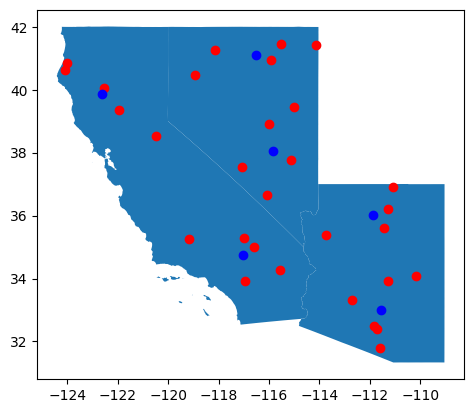

In [1605]:
ax = plz_shape_df.loc[lambda df: df["NAME"].isin(list_of_regions), "geometry"].plot()

region_store_coords = {}
region_warehouse_coords = {}

demand_nodes = {}
warehouse = {}

for region in list_of_regions:
    region_df = plz_shape_df.query(f'NAME == "{region}"')
    region_geo = region_df["geometry"]
    
    x, y = generate_random_location_within_ROI(number_of_demand_nodes//len(list_of_regions), region_geo)

    for i, point in enumerate(zip(x, y)):
        demand_nodes[f'store_{region.lower()}_{i+1}'] = point
    
    model_km = KMeans(n_clusters=number_of_warehouse//len(list_of_regions))
    model_km.fit(list(zip(x, y)))

    for i, point in enumerate(model_km.cluster_centers_):
        warehouse[f'warehouse_{region.lower()}_{i+1}'] = tuple(point)
        
    ax.plot(x, y, "ro")

    ax.plot([v[0] for v in model_km.cluster_centers_], 
        [v[1] for v in model_km.cluster_centers_], "bo")
plt.show()

# Generate skus

### Generate Ids

In [1606]:
# generate skus
def generate_sku(product, ppg):
    return f"{product}_{ppg}_"+"".join(
        [random.choice(string.digits) for i in range(3)]
    )

In [1607]:
distribution_skus = {
    'FOODS':0.7, 
    'HOUSHOLD': 0.2, 
    'HOBBIES':0.1
}

num_of_ppg = {
    'FOODS':3, 
    'HOUSHOLD': 2, 
    'HOBBIES':1
}

uints_on_pallet_by_product_type = {
    'FOODS': [8, 16, 32, 64, 128], 
    'HOUSHOLD': [4, 8, 16, 32, 64], 
    'HOBBIES':[1, 2, 4, 8, 16, 32]
}

weights_uints_on_pallet_by_product_type = {
    'FOODS': [8, 15, 15, 30, 30], 
    'HOUSHOLD': [5, 8, 15, 15, 30], 
    'HOBBIES':[1, 5, 8, 15, 15, 10]
}

In [1608]:
sku_list = []
sku_volume = {}
for product, weight in distribution_skus.items():
    num_product = int(num_skus*weight/num_of_ppg[product])
    
    for i in range(num_of_ppg[product]):
        for _ in range(num_product):
            sku = generate_sku(product, i+1)
            sku_list.append(sku)
            sku_volume[sku] = random.choices(
                uints_on_pallet_by_product_type[product], 
                weights=weights_uints_on_pallet_by_product_type[product])[0]

### Generate costs of procurement

In [1609]:
cost_by_volume  = {
    1: [50, 1000], 
    2: [50, 500], 
    4: [20, 500], 
    8: [20, 100], 
    16: [10, 100], 
    32: [5, 100], 
    64: [5, 50], 
    128: [2, 50]
}

sku_cost = {key: random.choices(range(
                                    cost_by_volume[value][0],
                                    cost_by_volume[value][1]
                                ))[0]
             for key, value in sku_volume.items()
             }

### Generate itemsets

In [1610]:
# generate items sets
import itertools
items_sets = []

for element in itertools.product(sku_list, sku_list):
    items_sets.append(tuple(set(sorted(element))))

In [1611]:
items_sets = list(set(items_sets))

In [1612]:
items_sets_enumerated = {}

for i, elements in enumerate(items_sets):
    items_sets_enumerated["["+", ".join(elements)+"]"] = elements

sku_itemsets = {value: key for key, value in items_sets_enumerated.items()}

In [1613]:
items_sets_enumerated_list = []

for key, elements in items_sets_enumerated.items():
    for element in elements:
        items_sets_enumerated_list.append(["["+", ".join(elements)+"]", element])

In [1614]:
df_itemsets = pd.DataFrame(
    items_sets_enumerated_list, columns=[col_itemsets_itemset_id, col_itemsets_sku_id])

In [1615]:
df_itemsets.to_csv(file_name_itemsets, index=False)

In [1616]:
df_itemsets.head(10)

,itemset_id,sku_id
0,[FOODS_2_455],FOODS_2_455
1,"[FOODS_1_548, FOODS_1_587]",FOODS_1_548
2,"[FOODS_1_548, FOODS_1_587]",FOODS_1_587
3,"[HOBBIES_1_902, FOODS_3_455]",HOBBIES_1_902
4,"[HOBBIES_1_902, FOODS_3_455]",FOODS_3_455
5,"[HOBBIES_1_906, FOODS_3_128]",HOBBIES_1_906
6,"[HOBBIES_1_906, FOODS_3_128]",FOODS_3_128
7,"[FOODS_3_154, HOUSHOLD_1_723]",FOODS_3_154
8,"[FOODS_3_154, HOUSHOLD_1_723]",HOUSHOLD_1_723
9,"[HOBBIES_1_305, FOODS_2_315]",HOBBIES_1_305


# Generate demand

In [1617]:
items_sets_stats_max_range = {}
for key in items_sets:
    if len(key) == 1:
        if sku_cost[key[0]]>500:
            items_sets_stats_max_range[key]= random.randint(1, 1)
        elif sku_cost[key[0]]>100:
            items_sets_stats_max_range[key]= random.randint(2, 10)
        elif sku_cost[key[0]]>50:
            items_sets_stats_max_range[key]= random.randint(10, 200)
        else:
            items_sets_stats_max_range[key]= random.randint(10, 500)
    else:
        if sku_cost[key[0]]>100 or sku_cost[key[1]]>100:
            items_sets_stats_max_range[key] = 0
        elif random.random()<percent_of_non_zero_itemsets:
            items_sets_stats_max_range[key] = random.randint(0, 10)
        else:
            items_sets_stats_max_range[key] = 0

In [1618]:
demand_nodes_demand_itemsets = {}
for node in demand_nodes.keys():
    for key in items_sets:
        demand_nodes_demand_itemsets[tuple((node,key))] = np.random.poisson(
            items_sets_stats_max_range[key], 1)[0]

In [1619]:
demand_skus = {}
for key, value in demand_nodes_demand_itemsets.items():
    for item in key[1]:
        demand_skus[item] = value + demand_skus.get(item, 0)

In [1620]:
df_demand_nodes = pd.DataFrame.from_dict(
    demand_nodes_demand_itemsets, orient='index').reset_index()

df_demand_nodes[[col_demand_demand_node_id,col_demand_itemset_id]] = pd.DataFrame(
    df_demand_nodes['index'].tolist(),index=df_demand_nodes.index)

df_demand_nodes = df_demand_nodes.drop(
    columns=['index']
).rename(
    {0: col_demand_demand_mean}, axis=1
)[[col_demand_demand_node_id, col_demand_itemset_id, col_demand_demand_mean]]

df_demand_nodes[col_demand_itemset_id] = df_demand_nodes[col_demand_itemset_id].apply(
    lambda x: sku_itemsets[x])

df_demand_nodes['demand_variance'] = 0

In [1621]:
df_demand_nodes.to_csv(file_name_demand, index=False)

In [1622]:
df_demand_nodes.head(20)

,node_id,itemset_id,demand_mean,demand_variance
0,store_california_1,[FOODS_2_455],118,0
1,store_california_1,"[FOODS_1_548, FOODS_1_587]",0,0
2,store_california_1,"[HOBBIES_1_902, FOODS_3_455]",0,0
3,store_california_1,"[HOBBIES_1_906, FOODS_3_128]",0,0
4,store_california_1,"[FOODS_3_154, HOUSHOLD_1_723]",0,0
5,store_california_1,"[HOBBIES_1_305, FOODS_2_315]",0,0
6,store_california_1,"[HOBBIES_1_222, HOUSHOLD_2_966]",0,0
7,store_california_1,"[FOODS_1_489, HOUSHOLD_1_769]",0,0
8,store_california_1,"[HOUSHOLD_1_513, FOODS_2_280]",0,0
9,store_california_1,"[FOODS_2_834, FOODS_3_879]",0,0


# Generate Capacity

In [1623]:
total_demand_units = sum(demand_skus.values())
total_capacity = int(capacity_over_demand_index * total_demand_units)

In [1624]:
print(f"Total demand in units: {total_demand_units}  Total capacity in warehouses: {total_capacity}")

Total demand in units: 763861  Total capacity in warehouses: 916633


### Distribution of Capacity 

In [1625]:
warehouses_capcaity_weight = []
for weight in warehouse.keys():
    warehouses_capcaity_weight.append(random.choice(range(5, 11)))

In [1626]:
warehouses_capcaity = {}
for i, idx in enumerate(warehouse.keys()):
    warehouses_capcaity[idx] = int(warehouses_capcaity_weight[i]/
                                   sum(warehouses_capcaity_weight)*
                                   total_capacity)

In [1627]:
df_supply_capacity = pd.DataFrame.from_dict(
    warehouses_capcaity, orient='index').reset_index().rename(
    {'index': col_capacity_supply_node_id, 0: col_capacity_capacity}, axis=1
)

In [1628]:
df_supply_capacity.to_csv(file_name_capacity, index=False)

In [1629]:
df_supply_capacity.head(10)

,node_id,capacity
0,warehouse_california_1,109122
1,warehouse_california_2,218245
2,warehouse_nevada_1,130947
3,warehouse_nevada_2,196421
4,warehouse_arizona_1,130947
5,warehouse_arizona_2,130947


### Current_quantity

In [1630]:
werhouses_occupation_total= {
    idx: int(warehouses_capcaity[idx]*random.random()*max_capacity_overtaken)
    for idx in warehouse.keys()}

In [1631]:
demand_skus_weight = {}
for key, value in demand_skus.items():
    demand_skus_weight[key] = value/total_demand_units

In [1632]:
werhouses_occupation_skus = {}

for idx, cap in werhouses_occupation_total.items():
    for sku, weight in demand_skus_weight.items():
        werhouses_occupation_skus[tuple((idx, sku))] = int(weight * cap)

In [1633]:
werhouses_cost_procurement_skus = {}

for idx, cap in warehouses_capcaity.items():
    for sku, cost in sku_cost.items():
        werhouses_cost_procurement_skus[tuple((idx, sku))] = max(1, cost + cost*np.random.randn()*0.1)

In [1634]:
df_supply_1 = pd.DataFrame.from_dict(
    werhouses_occupation_skus, orient='index').reset_index()

df_supply_1[[col_supply_supply_node_id,col_supply_sku_id]] = pd.DataFrame(
    df_supply_1['index'].tolist(),index=df_supply_1.index)

df_supply_1 = df_supply_1.drop(
    columns=['index']
).rename(
    {0: col_supply_current_quantity}, axis=1
)[[col_supply_supply_node_id, col_supply_sku_id, col_supply_current_quantity]]

In [1635]:
df_supply_2 = pd.DataFrame.from_dict(
    werhouses_cost_procurement_skus, orient='index').reset_index()

df_supply_2[[col_supply_supply_node_id,col_supply_sku_id]] = pd.DataFrame(
    df_supply_2['index'].tolist(),index=df_supply_2.index)

df_supply_2 = df_supply_2.drop(
    columns=['index']
).rename(
    {0: col_supply_cost}, axis=1
)[[col_supply_supply_node_id, col_supply_sku_id, col_supply_cost]]

In [1636]:
df_supply = pd.merge(
    df_supply_1, df_supply_2,  how='left', 
    left_on=[col_supply_supply_node_id,col_supply_sku_id], 
    right_on = [col_supply_supply_node_id,col_supply_sku_id])

In [1637]:
df_supply.to_csv(file_name_supply, index=False)

In [1638]:
df_supply.head()

,node_id,sku_id,current_quantity,cost
0,warehouse_california_1,FOODS_2_455,85,64.139851
1,warehouse_california_1,FOODS_1_548,115,61.683179
2,warehouse_california_1,FOODS_1_587,311,25.299692
3,warehouse_california_1,HOBBIES_1_902,41,32.857573
4,warehouse_california_1,FOODS_3_455,270,22.892649


# Shipping generate

In [1639]:
node_distance = {}
for idx_w, coord_1 in warehouse.items():
    for idx_dn, coord_2 in demand_nodes.items():
        coord_1 = tuple((radians(coord_1[0]), radians(coord_1[1])))
        coord_2 = tuple((radians(coord_2[0]), radians(coord_2[1])))

        node_distance[tuple((idx_w, idx_dn))] = geopy.distance.distance(
            coord_1, coord_2).km
        

In [1640]:
cost_of_unit_per_km = cost_per_km / (
    track_num_of_pallets*avg_num_of_units_on_pallet)

In [1641]:
cost_shipping_distance = {}
for key, dist in node_distance.items():
    cost_shipping_distance[key] = dist*cost_of_unit_per_km*real_vs_shortest_distace

In [1642]:
df_shipping = pd.DataFrame.from_dict(
    cost_shipping_distance, orient='index').reset_index()

df_shipping[[col_shipping_source_node_id,col_shipping_destination_node_id]] = pd.DataFrame(
    df_shipping['index'].tolist(),index=df_shipping.index)

df_shipping = df_shipping.drop(
    columns=['index']
).rename(
    {0: col_shipping_cost}, axis=1
)[[col_shipping_source_node_id, col_shipping_destination_node_id, col_shipping_cost]]

In [1643]:
df_shipping.to_csv(file_name_shipping, index=False)

In [1644]:
df_shipping.head()

,source_node_id,destination_node_id,cost
0,warehouse_california_1,store_california_1,0.029149
1,warehouse_california_1,store_california_2,0.517407
2,warehouse_california_1,store_california_3,0.526366
3,warehouse_california_1,store_california_4,0.537561
4,warehouse_california_1,store_california_5,0.521333
